In [102]:
!pip install folium
!pip install kmodes

from project_lib import Project
import numpy as np
import pandas as pd
import requests
import datetime
from pandas.io.json import json_normalize, json
import folium
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from kmodes.kmodes import KModes

In [2]:
# The code was removed by Watson Studio for sharing.

In [ ]:
header_column_list = ['astronomy', 'avgtempC', 'avgtempF', 'date', 'hourly', 'maxtempC', 'maxtempF', 'mintempC', 'mintempF', 'sunHour', 'totalSnow_cm', 'uvIndex']
df_result_nyc = pd.DataFrame(columns=header_column_list)
df_result_tokyo = pd.DataFrame(columns=header_column_list)
    
start_date = datetime.date(2012, 4, 1)
end_date = datetime.date(2013, 2, 20)
from_date = start_date
    
while from_date < end_date:
    to_date = from_date + datetime.timedelta(days=31)
    #print(str(previous) + ' - ' + str(date))
    #print('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=ec64962692ca48399ce223327201804&q=New York&format=json&date={start_date}&enddate={end_date}&tp=1'.format(start_date=str(previous), end_date=str(date)))
    result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={key}&q=New York&format=json&extra=utcDateTime&date={from_date}&enddate={to_date}&tp=1'.format(key= weatheronline_api_key, from_date=str(from_date), to_date=str(to_date)))
    df_result_nyc = df_result_nyc.append(pd.DataFrame(result.json()['data']['weather']))
    result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={key}&q=Tokyo&format=json&extra=utcDateTime&date={from_date}&enddate={to_date}&tp=1'.format(key= weatheronline_api_key, from_date=str(from_date), to_date=str(to_date)))
    df_result_tokyo = df_result_tokyo.append(pd.DataFrame(result.json()['data']['weather']))
    from_date = to_date + datetime.timedelta(days=1)
project.save_data("weather_nyc.csv", df_result_nyc.to_csv(index=False), overwrite=True)
project.save_data("weather_tokyo.csv", df_result_tokyo.to_csv(index=False), overwrite=True)

In [3]:
df_nyc = pd.read_csv(project.get_file('dataset_TSMC2014_NYC.csv'))
df_tokyo = pd.read_csv(project.get_file('dataset_TSMC2014_TKY.csv'))

df_nyc_weather = pd.read_csv(project.get_file('weather_nyc.csv'))
df_tokyo_weather = pd.read_csv(project.get_file('weather_tokyo.csv'))

df_nyc_weather['hourly'] = df_nyc_weather['hourly'].str.replace("'", '"')


In [4]:
df_nyc_weather_hourly_all = pd.DataFrame()
for index, row in df_nyc_weather.iterrows():
    #df_nyc_weather['hourly'][index]
    df_nyc_weather_hourly = json.loads(row['hourly'])
    df_nyc_weather_hourly = pd.DataFrame(df_nyc_weather_hourly)
    df_nyc_weather_hourly['sunHour'] = row['sunHour']
    df_nyc_weather_hourly_all = df_nyc_weather_hourly_all.append(df_nyc_weather_hourly, ignore_index = True)

In [5]:
list_drop_columns = ['DewPointC', 'DewPointF', 'FeelsLikeC', 'FeelsLikeF', 'HeatIndexC', 'HeatIndexF', 'WindChillC', 'WindChillF', 'uvIndex', 'visibility', 'visibilityMiles', 'WindGustKmph',
                     'WindGustMiles', 'visibility', 'visibilityMiles', 'weatherCode', 'weatherDesc', 'weatherIconUrl', 'winddir16Point', 'winddirDegree', 'windspeedKmph', 'windspeedMiles',
                     'precipInches', 'pressureInches', 'tempF', 'time']
df_nyc_weather_hourly_all.drop(columns=list_drop_columns, inplace=True)


In [6]:
replace_from_list = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']
replace_to_list = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
df_nyc_weather_hourly_all['UTCtime'] = df_nyc_weather_hourly_all['UTCtime'].replace(replace_from_list, replace_to_list)

In [7]:
df_nyc_weather_hourly_all['timestamp'] = pd.to_datetime(df_nyc_weather_hourly_all['UTCdate'] + " " + df_nyc_weather_hourly_all['UTCtime'])
df_nyc['timestamp'] = pd.to_datetime(df_nyc['utcTimestamp'], format='%a %b %d %X %z %Y').dt.tz_localize(None).dt.round('H')
df_nyc_w_weather = df_nyc.merge(df_nyc_weather_hourly_all, how='inner', on=['timestamp'])

In [8]:
df_nyc_w_weather['timestamp_loc'] = df_nyc_w_weather['timestamp'] + datetime.timedelta(hours=-4)

# Explore Data

In [9]:
df_nyc_w_weather.groupby(by=['venueCategory'])['userId'].count().sort_values(ascending=False).head(10)

venueCategory
Bar                     15555
Home (private)          14787
Office                  12336
Subway                   9048
Gym / Fitness Center     8882
Coffee Shop              7228
Food & Drink Shop        6340
Train Station            6164
Park                     4601
Neighborhood             4453
Name: userId, dtype: int64

In [10]:
df_nyc_w_weather.groupby(by=['venueCategory']).agg({'venueId': pd.Series.nunique}).sort_values(by='venueId', ascending=False).head(10)

,venueId
venueCategory,
Bar,2470
Office,1323
Home (private),1254
Food & Drink Shop,1182
Bus Station,1036
Clothing Store,987
Medical Center,857
Coffee Shop,842
Pizza Place,827


In [11]:
df_nyc_w_weather.groupby(by=['venueCategory'])['userId'].count().sort_values(ascending=True).head(10)

venueCategory
Music School              1
Motorcycle Shop           2
Photography Lab           2
Sorority House            2
Castle                    2
Pet Service               3
Afghan Restaurant         4
Gluten-free Restaurant    5
Internet Cafe             6
Portuguese Restaurant     7
Name: userId, dtype: int64

In [12]:
df_nyc_w_weather.groupby(by=['venueCategory']).agg({'venueId': pd.Series.nunique}).sort_values(by='venueId', ascending=True).head(10)

,venueId
venueCategory,
Sorority House,1
Motorcycle Shop,1
Music School,1
Castle,1
Swiss Restaurant,1
Aquarium,2
Photography Lab,2
Internet Cafe,3
Market,3


In [13]:
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for index, location in df_nyc_w_weather[['longitude', 'latitude', 'venueCategory']].drop_duplicates().iterrows():
    if location['venueCategory'] == 'Zoo':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='blue')
        ).add_to(nyc_map)
    elif location['venueCategory'] == 'Airport':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='red')
        ).add_to(nyc_map)
    elif location['venueCategory'] == 'Temple':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='green')
        ).add_to(nyc_map)
nyc_map

# Segment Data with K-Mode

In [14]:
df_nyc_w_weather['season_bin'] = pd.cut(df_nyc_w_weather['timestamp_loc'].dt.month, bins=[1, 2, 5, 8, 11, 12], labels=['winter_1', 'spring', 'summer', 'autumn', 'winter_2'], include_lowest =True)
df_nyc_w_weather['season_bin'] = df_nyc_w_weather['season_bin'].replace(['winter_1', 'winter_2'], ['winter', 'winter'])

df_nyc_w_weather['day_bin'] = pd.cut(df_nyc_w_weather['timestamp_loc'].dt.hour, bins=[0, 5, 10, 12, 16, 20, 23], labels=['night_1', 'morning', 'noon', 'afternoon', 'evening', 'night_2'], include_lowest =True)
df_nyc_w_weather['day_bin'] = df_nyc_w_weather['day_bin'].replace(['night_1', 'night_2'], ['night', 'night'])

df_nyc_w_weather['day_ow_bin'] = df_nyc_w_weather['timestamp_loc'].dt.strftime('%A')

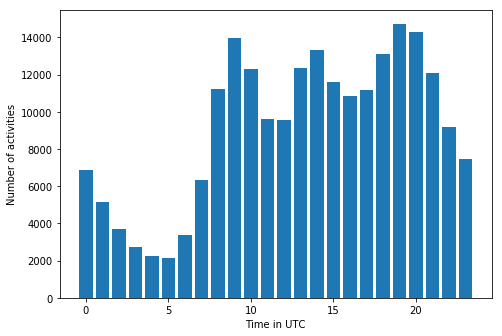

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nyc_w_weather['timestamp_loc'].groupby(df_nyc_w_weather['timestamp_loc'].dt.hour).size().index, df_nyc_w_weather['timestamp_loc'].groupby(df_nyc_w_weather['timestamp_loc'].dt.hour).size())
ax.set_xlabel('Time in UTC')
ax.set_ylabel('Number of activities')
plt.show()

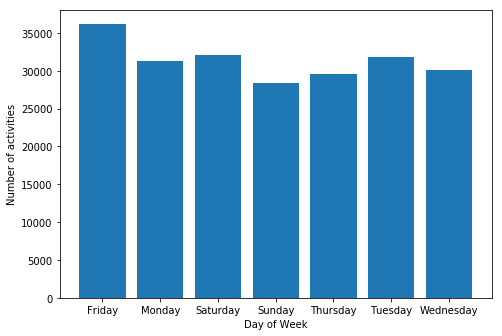

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nyc_w_weather.groupby(df_nyc_w_weather['day_ow_bin']).size().index, df_nyc_w_weather['day_ow_bin'].groupby(df_nyc_w_weather['day_ow_bin']).size())
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of activities')
plt.show()

In [17]:
df_nyc_w_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219501 entries, 0 to 219500
Data columns (total 21 columns):
userId             219501 non-null int64
venueId            219501 non-null object
venueCategoryId    219501 non-null object
venueCategory      219501 non-null object
latitude           219501 non-null float64
longitude          219501 non-null float64
timezoneOffset     219501 non-null int64
utcTimestamp       219501 non-null object
timestamp          219501 non-null datetime64[ns]
UTCdate            219501 non-null object
UTCtime            219501 non-null object
cloudcover         219501 non-null object
humidity           219501 non-null object
precipMM           219501 non-null object
pressure           219501 non-null object
tempC              219501 non-null object
sunHour            219501 non-null float64
timestamp_loc      219501 non-null datetime64[ns]
season_bin         219501 non-null object
day_bin            219501 non-null object
day_ow_bin         219501 non-nu

In [18]:
# Validate Date (if time conversion <> hat worked properly and all categories were assigned properly) before removing cols

In [19]:
drop_col_list = ['venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset', 'utcTimestamp', 'timestamp', 'UTCdate', 'UTCtime', 'timestamp_loc']
df_nyc_w_weather_ml = df_nyc_w_weather.drop(columns = drop_col_list, axis=1)

In [20]:
LE = preprocessing.LabelEncoder()
df_nyc_w_weather_ml = df_nyc_w_weather_ml.apply(LE.fit_transform)

In [21]:
cost = []

for attempts in list(range(1,8)):
    km_cao = KModes(n_clusters=attempts, init = "Cao", n_init = 1, verbose=1)
    fitClusters_cao = km_cao.fit_predict(df_nyc_w_weather_ml.reset_index(drop=True))
    cost.append(km_cao.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1925028.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7890, cost: 1836219.0
Run 1, iteration: 2/100, moves: 982, cost: 1836219.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9659, cost: 1774833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7616, cost: 1727685.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7431, cost: 1701186.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5687, cost: 1687923.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5869, cost: 1672358.0


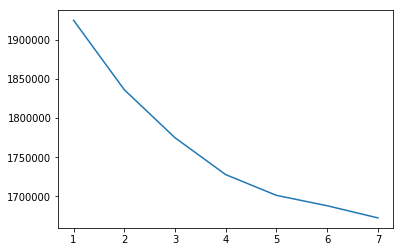

In [22]:
y = np.array([i for i in range(1, 8, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

# Adapt Data

In [23]:
drop_col_list = ['venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset', 'utcTimestamp', 'timestamp', 'UTCdate', 'UTCtime', 'timestamp_loc', 'userId', 'cloudcover', 'humidity', 'precipMM', 'pressure']

df_nyc_w_weather_advanced = df_nyc_w_weather.drop(columns = drop_col_list, axis=1)
df_nyc_w_weather_advanced[['sunHour']] = df_nyc_w_weather_advanced[['sunHour']].astype('float').round(decimals=0)
df_nyc_w_weather_advanced = df_nyc_w_weather_advanced.astype({'tempC': 'int16', 'sunHour': 'int16'})
df_nyc_w_weather_advanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219501 entries, 0 to 219500
Data columns (total 6 columns):
venueCategory    219501 non-null object
tempC            219501 non-null int16
sunHour          219501 non-null int16
season_bin       219501 non-null object
day_bin          219501 non-null object
day_ow_bin       219501 non-null object
dtypes: int16(2), object(4)
memory usage: 9.2+ MB


In [24]:
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
cost = []

for attempts in list(range(1,11)):
    km_cao = KModes(n_clusters=attempts, init = "Cao", n_init = 1, verbose=1)
    fitClusters_cao = km_cao.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_cao.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1046202.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 961471.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 898051.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 853886.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 830573.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 821123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 811342.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, it

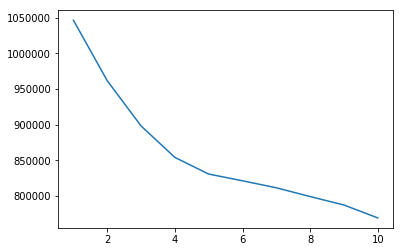

In [25]:
y = np.array([i for i in range(1, 11, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

In [67]:
drop_columns = ['Bar', 'Food & Drink Shop', 'Clothing Store', 'Coffee Shop', 'Pizza Place', 'American Restaurant', 'Deli / Bodega', 'Gym / Fitness Center', 'Italian Restaurant',
               'Park', 'Chinese Restaurant', 'Fast Food Restaurant', 'Sandwich Place', 'Mexican Restaurant', 'Bakery','Café','Diner', 'General Entertainment', 'Burger Joint',
               'Sushi Restaurant', 'Theater', 'Art Gallery', 'Food Truck', 'Athletic & Sport', 'Ice Cream Shop', 'Spa / Massage', 'Bagel Shop', 'Donut Shop', 'Asian Restaurant',
               'French Restaurant', 'Thai Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Indian Restaurant']

df_nyc_w_weather_advanced = df_nyc_w_weather_advanced[df_nyc_w_weather_advanced['venueCategory'].isin(drop_columns)]
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)

In [27]:
cost = []

for attempts in list(range(1,31)):
    km_cao = KModes(n_clusters=attempts, init = "Cao", n_init = 1, verbose=1)
    fitClusters_cao = km_cao.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_cao.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 377815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 342371.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 319273.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 306020.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 295666.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 290589.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 772, cost: 283679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, i

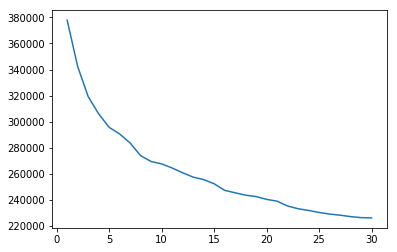

In [28]:
y = np.array([i for i in range(1, 31, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

In [29]:
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
cost = []

for attempts in list(range(1,31)):
    km_Huang = KModes(n_clusters=attempts, init = "Huang", n_init = 1, verbose=1)
    fitClusters_Huang = km_Huang.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_Huang.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 377815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10103, cost: 347202.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 23540, cost: 318442.0
Run 1, iteration: 2/100, moves: 11003, cost: 318442.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7013, cost: 323917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10203, cost: 294462.0
Run 1, iteration: 2/100, moves: 109, cost: 294462.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 19891, cost: 289493.0
Run 1, iteration: 2/100, moves: 5628, cost: 289493.0
Init: initializing centroids
Init: initial

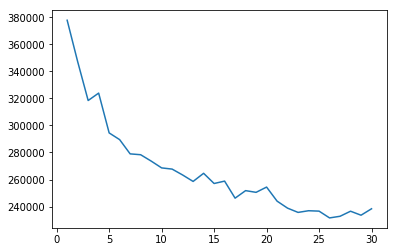

In [30]:
y = np.array([i for i in range(1, 31, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

In [31]:
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
cost = []

for attempts in list(range(1,11)):
    km_Huang = KModes(n_clusters=attempts, init = "Huang", n_init = 1, verbose=1)
    fitClusters_Huang = km_Huang.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_Huang.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 377815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14831, cost: 336249.0
Run 1, iteration: 2/100, moves: 84, cost: 336249.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 24608, cost: 318003.0
Run 1, iteration: 2/100, moves: 2275, cost: 318003.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 318140.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11558, cost: 295345.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 21720, cost: 290084.0
Run 1, iteration: 2/100, moves: 174, cost: 290084.0
Init: initializing centroids
Init: initializing 

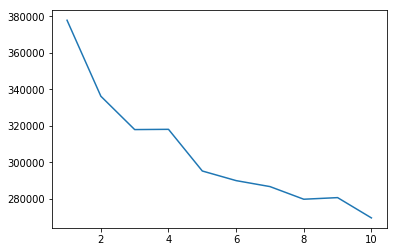

In [32]:
y = np.array([i for i in range(1, 11, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

Best Algorithm is Huang and best K is 8

In [68]:
k = 8
km_Huang = KModes(n_clusters=k, init = "Huang", n_init = 1, verbose=1)
fitClusters_Huang = km_Huang.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 21553, cost: 278392.0
Run 1, iteration: 2/100, moves: 1703, cost: 278392.0


In [91]:
clusterDf = pd.DataFrame(fitClusters_Huang)
#clusterDf.rename(columns={0:'cluster_predicted'}, inplace=True)
clusterDf.columns = ['cluster_predicted']
clusterDf = pd.concat([df_nyc_w_weather_advanced.reset_index(), clusterDf], axis=1).reset_index()
clusterDf = clusterDf.drop(['index'], axis=1)

In [97]:
clusterDf_0 = clusterDf.loc[clusterDf['cluster_predicted'] == 0]
clusterDf_1 = clusterDf.loc[clusterDf['cluster_predicted'] == 1]
clusterDf_2 = clusterDf.loc[clusterDf['cluster_predicted'] == 2]
clusterDf_3 = clusterDf.loc[clusterDf['cluster_predicted'] == 3]
clusterDf_4 = clusterDf.loc[clusterDf['cluster_predicted'] == 4]
clusterDf_5 = clusterDf.loc[clusterDf['cluster_predicted'] == 5]
clusterDf_6 = clusterDf.loc[clusterDf['cluster_predicted'] == 6]
clusterDf_7 = clusterDf.loc[clusterDf['cluster_predicted'] == 7]

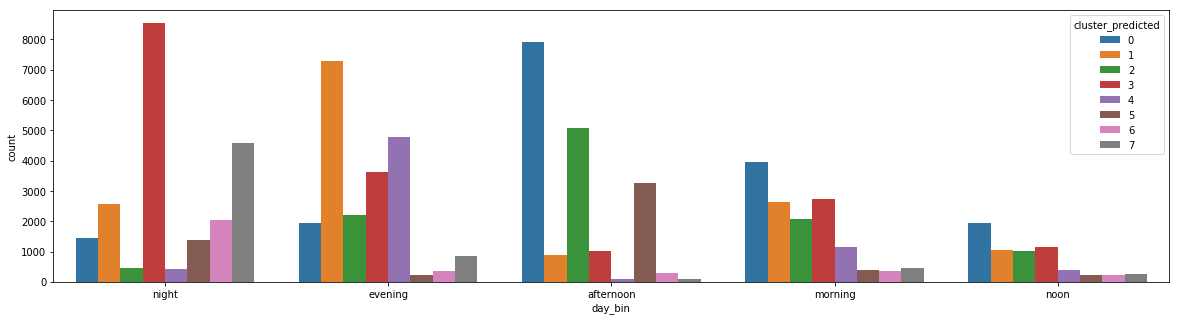

In [106]:
plt.subplots(figsize = (20,5))
sns.countplot(x=clusterDf['day_bin'],order=clusterDf['day_bin'].value_counts().index,hue=clusterDf['cluster_predicted'])
plt.show()

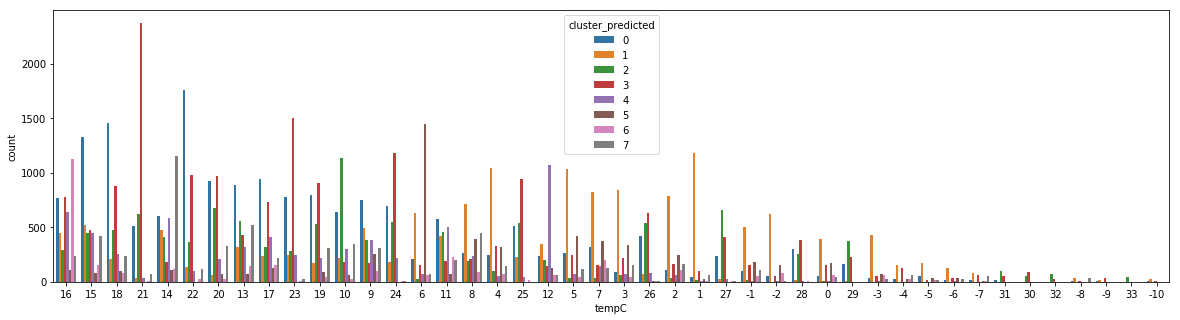

In [107]:
plt.subplots(figsize = (20,5))
sns.countplot(x=clusterDf['tempC'],order=clusterDf['tempC'].value_counts().index,hue=clusterDf['cluster_predicted'])
plt.show()

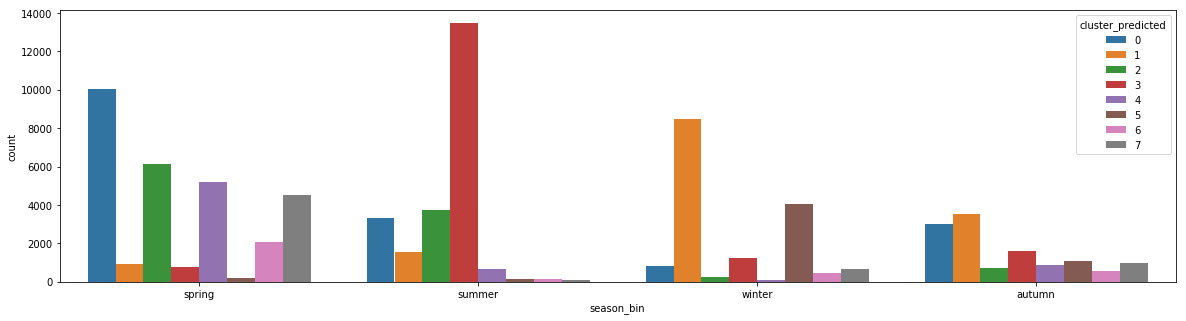

In [108]:
plt.subplots(figsize = (20,5))
sns.countplot(x=clusterDf['season_bin'],order=clusterDf['season_bin'].value_counts().index,hue=clusterDf['cluster_predicted'])
plt.show()

In [ ]:
plt.subplots(figsize = (20,5))
sns.countplot(x=clusterDf['venueCategory'],order=clusterDf['venueCategory'].value_counts().index,hue=clusterDf['cluster_predicted'])
plt.show()

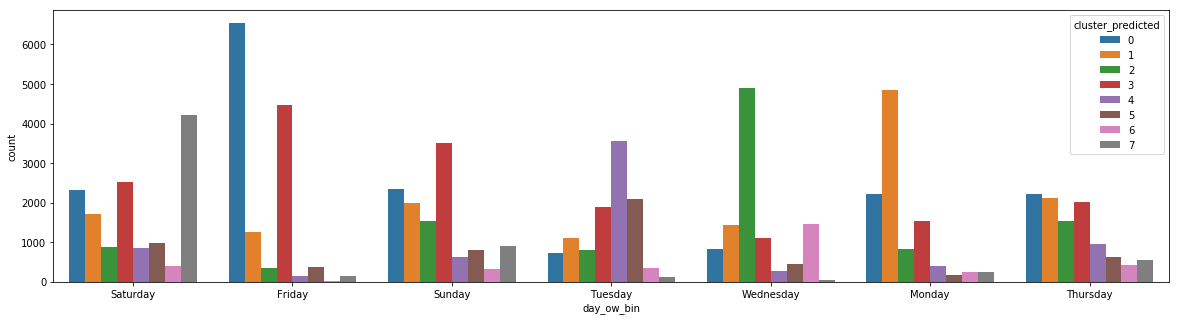

In [109]:
plt.subplots(figsize = (20,5))
sns.countplot(x=clusterDf['day_ow_bin'],order=clusterDf['day_ow_bin'].value_counts().index,hue=clusterDf['cluster_predicted'])
plt.show()

# Predict